In [15]:
import numpy as np
import cv2
from skimage import data, io, filters
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.filters import sobel
from pandas import DataFrame

from skimage.feature import greycomatrix, greycoprops

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from random import randint
from skimage import data, segmentation, color
from skimage.future import graph

Abrimos imagen con OpenCV, debido a esto convertimos la imagen de BGR a RGB y a escala de grises para poder trabajar con la matriz GLCM

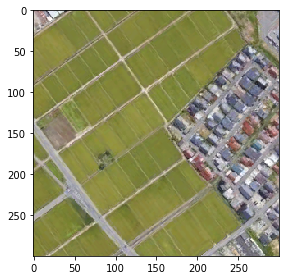

In [3]:
img = cv2.imread('.\\satelite\\P1.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
io.imshow(img_rgb)


## Método SLIC

Se utilizó el método SLIC para la creación de superpixeles, esto gracias a que la función de SkImage tiene la opción de elegir un número aproximado de superpixeles para la imagen.

Segmentos del algoritmo SLIC: 36


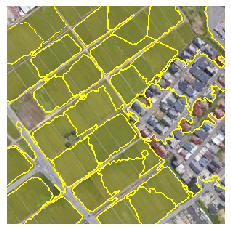

In [61]:
segments_slic = slic(img_rgb, n_segments = 45, compactness=10, sigma=1)
print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slic))}")

fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), segments_slic))
plt.axis("off")
plt.show()

Se obtiene la matriz GLCM para cada superpixel y se obtiene un vector característico con la información e energíam contraste y correlación.

In [62]:
infoEnergiaSLIC = []
infoContrasteSLIC = []
infoCorrelacionSLIC = []

superpixeles = len(np.unique(segments_slic))

for (i, segVal) in enumerate(np.unique(segments_slic)):
    mask = np.zeros(img_rgb.shape[:2], dtype = "uint8")
    #Mascara binaria
    mask[segments_slic == segVal] = 255
    mask = cv2.bitwise_and(img_rgb, img_rgb, mask = mask)

    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(mask_gray, [1], [0], 256, symmetric=True, normed=True)
    filt_glcm = glcm[1:, 1:, :, :]
    infoContrasteSLIC.append(greycoprops(filt_glcm, prop='contrast'))
    infoEnergiaSLIC.append(greycoprops(filt_glcm, prop='energy'))
    infoCorrelacionSLIC.append(greycoprops(filt_glcm, prop='correlation'))

Correlacion = np.asarray(infoCorrelacionSLIC, dtype=float).reshape((superpixeles, 1))
#print(Correlacion)
Energia = np.asarray(infoEnergiaSLIC, dtype=float).reshape((superpixeles, 1))
#print(Energia)
Contraste = np.asarray(infoContrasteSLIC, dtype=float).reshape((superpixeles, 1))
#print(Contraste)

Preparamos los datos para el entrenamiento

In [63]:
X_100 = np.zeros((len(np.unique(segments_slic)), 3))
for i in range(len(X_100)): 
    for j in range(len(X_100[i])):
        if(j == 0):
            X_100[i][j] = Correlacion[i]
        if(j == 1):
            X_100[i][j] = Energia[i]
        if(j == 2):
            X_100[i][j] = Contraste[i]

print(X_100)
Y_100 = np.zeros(superpixeles)
flag = 0
for i in range(4):
    Y_100[flag:flag+9] = i
    flag = flag + 9

print(Y_100)

[[8.83794347e-01 7.62052894e-02 2.91294420e+02]
 [7.53703456e-01 3.81419500e-02 3.03593565e+02]
 [7.70881020e-01 1.18961219e-01 1.24594059e+01]
 [8.23102353e-01 1.10326645e-01 2.70255428e+01]
 [5.92937365e-01 1.28608087e-01 1.88648294e+01]
 [8.00747919e-01 2.70082035e-02 2.89544789e+02]
 [6.58700243e-01 4.37063590e-02 2.56881603e+02]
 [7.73393541e-01 1.16688770e-01 7.40953947e+00]
 [5.44774388e-01 1.24683112e-01 2.90233503e+01]
 [5.63821413e-01 1.03769915e-01 2.03060061e+01]
 [7.77919960e-01 3.91882474e-02 3.90710217e+02]
 [6.88551704e-01 9.66815910e-02 1.96114790e+01]
 [8.11598226e-01 1.74191157e-02 4.70014770e+02]
 [6.16224573e-01 7.25983297e-02 8.03019161e+01]
 [6.49054235e-01 1.31518749e-01 1.53521940e+01]
 [6.01013693e-01 6.97097537e-02 1.33757177e+02]
 [7.23450106e-01 6.36239633e-02 4.06334541e+01]
 [8.40005983e-01 2.85819218e-02 2.17587945e+02]
 [8.26608046e-01 1.67632063e-02 5.18165569e+02]
 [8.18871686e-01 6.23474074e-02 8.58530594e+01]
 [7.61579666e-01 2.19410437e-02 3.975691

In [64]:
#VECTORES TEST Y VECTORES DE ENTRENAMIENTO, COMIENZA ENTRENAMIENTO
X_train100, X_test100, y_train100, y_test100 = train_test_split(X_100, Y_100, test_size=0.3, random_state=1, stratify=Y_100)

#IMPRIMIMOS EL VECTOR DE TEST QUE SALE
print(X_test100)

[[7.77919960e-01 3.91882474e-02 3.90710217e+02]
 [6.88551704e-01 9.66815910e-02 1.96114790e+01]
 [6.01013693e-01 6.97097537e-02 1.33757177e+02]
 [8.18871686e-01 6.23474074e-02 8.58530594e+01]
 [8.83794347e-01 7.62052894e-02 2.91294420e+02]
 [7.73393541e-01 1.16688770e-01 7.40953947e+00]
 [5.99505394e-01 7.07947116e-02 4.49484761e+01]
 [7.61579666e-01 2.19410437e-02 3.97569128e+02]
 [5.74320310e-01 1.37828729e-01 1.91211017e+01]
 [8.00747919e-01 2.70082035e-02 2.89544789e+02]
 [8.63802165e-01 9.52936400e-02 4.19667622e+01]]


## KNN

In [65]:
# CREAMOS EL CLASIFICADOR 
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train100,y_train100)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [66]:
#PROBAMOS EL CLASIFICADOR CON EL VECTOR TEST QUE SE IMPRIMIO ARRIBA, DA LOS RESULTADOS 1 SI PERTENECE A TEXTURA 2, 0 SI ES TEXTURA 1
print("\npredicción")
print(knn.predict(X_test100))

print("\nreal")
print(y_test100)

#QUE TAN CORRECTO ESTUVO
knn.score(X_test100, y_test100)


predicción
[0. 0. 2. 1. 0. 0. 3. 0. 0. 0. 3.]

real
[1. 1. 1. 2. 0. 0. 3. 2. 2. 0. 3.]


0.45454545454545453

## KMeans

[-3311473.765537846, -689366.4486056027, -343123.2556583108, -157090.16095776844, -99649.0779064429, -71322.78382254591, -45390.50477834277, -33911.07182377359, -24230.824069571398]


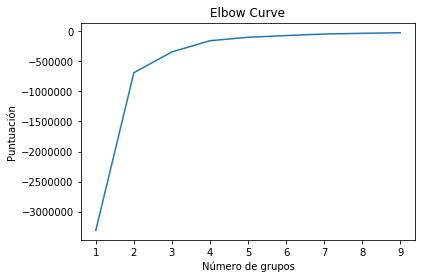

In [55]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_100).score(X_100) for i in range(len(kmeans))]
print(score)
plt.plot(Nc,score)
plt.xlabel('Número de grupos')
plt.ylabel('Puntuación')
plt.title('Elbow Curve')
plt.show()

[[7.61184571e-01 2.73522499e-02 5.40788459e+02]
 [6.93354413e-01 1.03176977e-01 3.63623883e+01]
 [7.64997891e-01 4.05997216e-02 2.60756978e+02]]
[0 1 1 2 1 1 1 1 2 2 1 2 1 1 1 2 1 0 1 1 0 1 1 1 0 0 0 1 2 2 1 0 1 1 2 0 1
 1 2 0 1 1 0 1 1 0 1 2 2 1 2 2 1 1 0 2 1 2 1 1 1 0 1 2 1 1 1 1 1 2 1 0 1 0
 1 1]


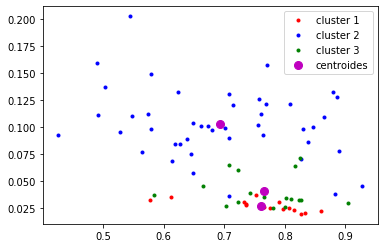

In [60]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_100)


kmeans = KMeans(n_clusters=3).fit(X_100)
centroids = kmeans.cluster_centers_
etiquetas = kmeans.labels_
print(centroids)
print(etiquetas)



plt.plot(X_100[etiquetas==0,0],X_100[etiquetas==0,1],'r.', label='cluster 1')
plt.plot(X_100[etiquetas==1,0],X_100[etiquetas==1,1],'b.', label='cluster 2')
plt.plot(X_100[etiquetas==2,0],X_100[etiquetas==2,1],'g.', label='cluster 3')

plt.plot(centroids[:,0],centroids[:,1],'mo',markersize=8, label='centroides')

plt.legend(loc='best')
plt.show()

## Pruebas

(300, 300, 3)


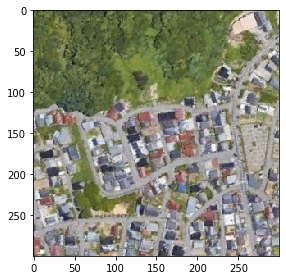

In [35]:
prueba = cv2.imread('.\\satelite\\p2.png')
prueba_rgb = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)
prueba_gray = cv2.cvtColor(prueba, cv2.COLOR_BGR2GRAY)
print(prueba_rgb.shape)
io.imshow(prueba_rgb)

Segmentos del algoritmo SLIC: 15


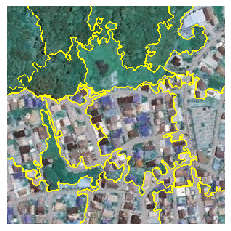

In [73]:
segments_slicP = slic(prueba_rgb, n_segments = 22, compactness=10, sigma=1)
print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slicP))}")

fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img_as_float(cv2.cvtColor(prueba_rgb, cv2.COLOR_BGR2RGB)), segments_slicP))
plt.axis("off")
plt.show()

In [74]:
infoEnergiaSLIC_P = []
infoContrasteSLIC_P = []
infoCorrelacionSLIC_P = []

superpixelesP = len(np.unique(segments_slicP))

for (i, segVal) in enumerate(np.unique(segments_slicP)):
    mask = np.zeros(prueba_rgb.shape[:2], dtype = "uint8")
    #Mascara binaria
    mask[segments_slicP == segVal] = 255
    mask = cv2.bitwise_and(prueba_rgb, prueba_rgb, mask = mask)

    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(mask_gray, [1], [0], 256, symmetric=True, normed=True)
    filt_glcm = glcm[1:, 1:, :, :]
    infoContrasteSLIC_P.append(greycoprops(filt_glcm, prop='contrast'))
    infoEnergiaSLIC_P.append(greycoprops(filt_glcm, prop='energy'))
    infoCorrelacionSLIC_P.append(greycoprops(filt_glcm, prop='correlation'))

CorrelacionP = np.asarray(infoCorrelacionSLIC_P, dtype=float).reshape((superpixelesP, 1))
#print(Correlacion)
EnergiaP = np.asarray(infoEnergiaSLIC_P, dtype=float).reshape((superpixelesP, 1))
#print(Energia)
ContrasteP = np.asarray(infoContrasteSLIC_P, dtype=float).reshape((superpixelesP, 1))
#print(Contraste)

In [75]:
X_P = np.zeros((len(np.unique(segments_slicP)), 3))
for i in range(len(X_P)): 
    for j in range(len(X_P[i])):
        if(j == 0):
            X_P[i][j] = CorrelacionP[i]
        if(j == 1):
            X_P[i][j] = EnergiaP[i]
        if(j == 2):
            X_P[i][j] = ContrasteP[i]


print(X_P)
pred = knn.predict(X_P)
print(pred)


predKmeans = kmeans.predict(X_P)
print(predKmeans)

[[6.73239538e-01 2.48744563e-02 1.82600216e+02]
 [6.55582777e-01 2.64438162e-02 1.63211493e+02]
 [6.69431448e-01 2.95328226e-02 1.27264154e+02]
 [6.99081403e-01 2.94839243e-02 1.25675316e+02]
 [8.56681009e-01 1.43570419e-02 4.90081395e+02]
 [8.64664801e-01 3.26175614e-02 1.02139573e+02]
 [6.68305572e-01 2.81779341e-02 1.39655058e+02]
 [8.04482696e-01 1.64873914e-02 4.23981687e+02]
 [8.66898646e-01 1.35548045e-02 4.15942745e+02]
 [8.38075208e-01 1.87908011e-02 4.26169745e+02]
 [8.53531762e-01 1.50879070e-02 4.57142123e+02]
 [8.97953220e-01 2.14451139e-02 2.44077354e+02]
 [8.48864465e-01 1.55295230e-02 4.87617549e+02]
 [8.33431195e-01 1.57312429e-02 5.18374102e+02]
 [8.58587067e-01 1.56148675e-02 4.00038633e+02]]
[0. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 0. 1. 2. 0.]
[2 2 1 1 0 1 1 0 0 0 0 2 0 0 2]


In [71]:
def mascar(tipo,ventana):
    if tipo==0:
        ventanagris=ventana*0+64 
    elif tipo==1:
        ventanagris=ventana*0+128
    elif tipo==2:
        ventanagris=ventana*0+192

    return ventanagris